# Final Project Submission

- Student name: Sabina Bains
- Student pace: Self Paced
- Scheduled project review date / time: XXX
- Instructor name: Claude Fried

# Summary

Add Summary here


data - https://www.kaggle.com/code/anayad/classifying-cyberbullying-tweets/data


# Business Understanding

# Data Understanding

#### Reading in Necessary Packages

In [206]:
import pandas as pd
from nltk.tokenize import RegexpTokenizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score, train_test_split
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from sklearn.metrics import plot_confusion_matrix
from nltk.util import ngrams
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib as mpl

import warnings
warnings.filterwarnings('ignore')

COLOR = 'white'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

In [207]:
# Split then vectorize (correct way)
# We do the train/test split before the CountVectorizer to properly simulate the real world where our future data contains words we have not seen before

#### Reading in Data

In [217]:
df = pd.read_csv('data/cyberbullying_tweets.csv')


# replacing offensive words
df.tweet_text = df.tweet_text.str.replace('ggers','xxxxx')
df.tweet_text = df.tweet_text.str.replace('gger','xxxx')

#### Understanding Labels

In [218]:
# checking distribution of target values - looks like a balanced dataset
pd.DataFrame(df.cyberbullying_type.value_counts(normalize=True))

,cyberbullying_type
religion,0.167701
age,0.167575
gender,0.167177
ethnicity,0.166925
not_cyberbullying,0.166590
other_cyberbullying,0.164032


In [219]:
# standardizing words to all be lowercase
def lowercase(x):
    return x.lower()

df.tweet_text = df.tweet_text.apply(lowercase)

In [220]:
# tokenizing words in df to inspect differences in cyberbullying classes
def tokenize(x):
    token_pattern = r"(?u)\b\w\w+\b"
    tokenizer = RegexpTokenizer(token_pattern)
    return tokenizer.tokenize(x)

df['tokens'] = df.tweet_text.apply(tokenize)

In [221]:
# removing stopwords from data
stopwords_list = stopwords.words('english')

def remove_stopwords(token_list):
    return [word for word in token_list if word not in stopwords_list]

df.tokens = df.tokens.apply(remove_stopwords)

FreqDist(df.tokens.explode()).most_common(30)[22:25]

[('mkr', 2543), ('muslims', 2513), ('muslim', 2491)]

In [222]:
# Above we can see we need to stem the data (muslim vs. muslims)
stemmer = SnowballStemmer(language="english")

def stem(tweets):
    return [stemmer.stem(tweet) for tweet in tweets]

df.tokens = df.tokens.apply(stem)

In [223]:
# testing the stemmer : 
connect_list = ['CONNECT','CONNECTIONS','CONNECTED','CONNECTING','CONNECTION']
stem(connect_list)

['connect', 'connect', 'connect', 'connect', 'connect']

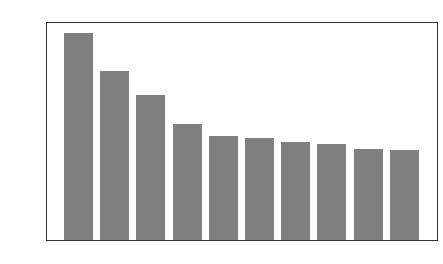

In [224]:
total_top_10 = FreqDist(df.tokens.explode()).most_common(10)

tokens = [word[0] for word in total_top_10]
counts = [value[1] for value in total_top_10]

fig = plt.figure(figsize=(7,4))
plt.bar(tokens,counts, color= 'grey')
plt.title('Top Tokens')
plt.show()

In [225]:
wordsdf = pd.DataFrame(FreqDist(df.tokens.explode()), index =[1]).T

In [226]:
wordsdf.to_csv('/Users/sabinabains/Desktop/export.csv')

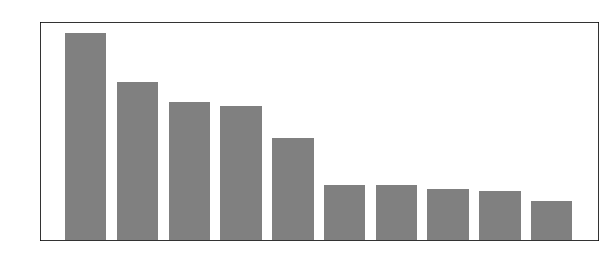

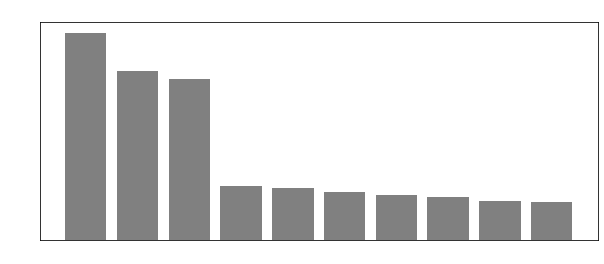

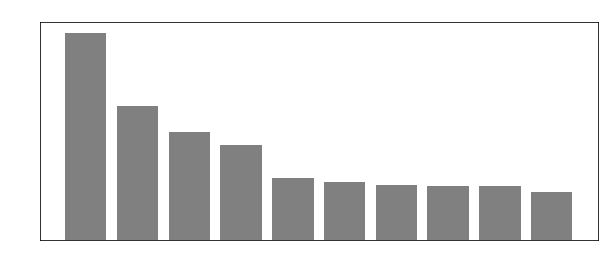

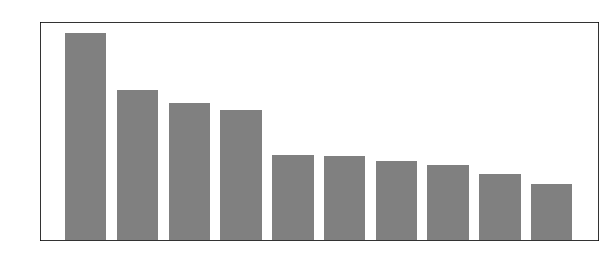

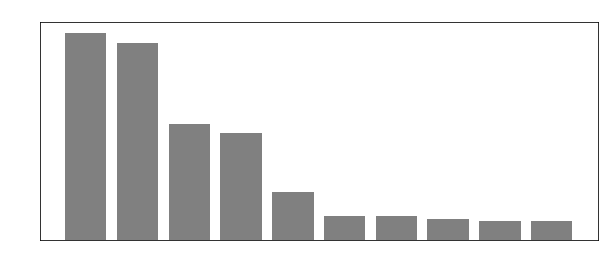

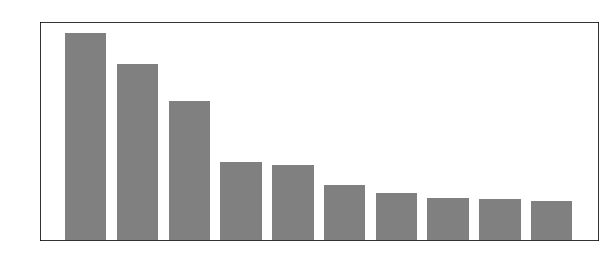

In [228]:
# Creating frequency distributions for each label to visually inspect most common words in each tag
freq_dict = {}

for target in df.cyberbullying_type.unique():
    freq_dict[target] = FreqDist(df.loc[df.cyberbullying_type == target].tokens.explode())
    
    top_10 = list(zip(*freq_dict[target].most_common(10)))
    tokens = top_10[0]
    counts = top_10[1]

    fig = plt.figure(figsize=(10,4))
    plt.bar(tokens,counts, color = 'grey')
    plt.title('Top tokens for '+target)
    plt.show()

#### Splitting Tweets and Labels into two dataframes

In [78]:
X = pd.DataFrame(df.tweet_text)
y = df.cyberbullying_type

#### Performing Train Test Split for Data Validation

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [80]:
# plot_confusion_matrix(baseline_model, X_train, df['cyberbullying_type']);

## creating bigrams

In [81]:
def bigram(tweet):
    return [' '.join(word) for word in ngrams(tweet, 2)]

def _3gram(tweet):
    return [' '.join(word) for word in ngrams(tweet, 3)]

df['bigram'] = df.tokens.apply(bigram)
df['_3gram'] = df.tokens.apply(_3gram)

In [82]:
FreqDist(df._3gram.explode()).most_common(10)

[('bulli high school', 1539),
 ('dumb ass nixxxx', 1170),
 (nan, 1127),
 ('fuck obama dumb', 979),
 ('obama dumb ass', 966),
 ('tayyoung_ fuck obama', 956),
 ('girl bulli high', 824),
 ('high school bulli', 653),
 ('rt tayyoung_ fuck', 456),
 ('girl high school', 415)]

In [83]:
# from sklearn.pipeline import Pipeline
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
# from sklearn.model_selection import train_test_split, GridSearchCV
# text_clf = Pipeline([('vect', CountVectorizer()),
#                      ('tfidf', TfidfTransformer()),
#                      ('clf', MultinomialNB())])
# tuned_parameters = {
#     'vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
#     'tfidf__use_idf': (True, False),
#     'tfidf__norm': ('l1', 'l2'),
#     'clf__alpha': [1, 1e-1, 1e-2]
# }

# MODELING

In [84]:
# creating a function to evaluate models

def evaluate_multinomialnb(tfidf, model, X_train, X_test):
    
    #vectorizing data
    X_train_v = tfidf.fit_transform(X_train.tweet_text)
    X_test_v = tfidf.transform(X_test.tweet_text)
    
    # computing mean accuracy
    train_acc = cross_val_score(model, X_train_v, y_train).mean()
    test_acc = cross_val_score(model, X_test_v, y_test).mean()

    print('Training Accuracy: {:.1%}'.format(train_acc))
    print('Testing Accuracy: {:.1%}'.format(test_acc))

#### Baseline Model

In [85]:
# initializing basic TFIDF vectorizer with 50 words with highest tfidf values
tfidf_1 = TfidfVectorizer(max_features=50)
model_1 = MultinomialNB()

evaluate_multinomialnb(tfidf_1, model_1, X_train, X_test)

print('''\nOur baseline model performs relatively well, if we were to randomly classify cyberbullying we would get an accuracy of 16.6%, whereas our model has an
accuracy of over 3x better. However this model will still predict correctly only about half the time. Let's try to improve it by removing stopwords.''')

Training Accuracy: 56.4%
Testing Accuracy: 57.5%

Our baseline model performs relatively well, if we were to randomly classify cyberbullying we would get an accuracy of 16.6%, whereas our model has an
accuracy of over 3x better. However this model will still predict correctly only about half the time. Let's try to improve it by removing stopwords.


#### Model #2 - removing stopwords

In [86]:
stopwords_list = stopwords.words('english')

In [87]:
# Instantiate the vectorizer
tfidf_2 = TfidfVectorizer(
    max_features=50,
    stop_words=stopwords_list
)

evaluate_multinomialnb(tfidf_2, model_1, X_train, X_test)

print('''\n Our model has significantly improved once removing stopwords. Let's continue to tweak by stemming words, as we saw earlier that some words are considered
different when they have the same meaning''')

Training Accuracy: 64.0%
Testing Accuracy: 68.9%

 Our model has significantly improved once removing stopwords. Let's continue to tweak by stemming words, as we saw earlier that some words are considered
different when they have the same meaning


#### Model #3 - Removed Stopwords and Stemmed

In [88]:
# Instantiate the vectorizer
tfidf_3 = TfidfVectorizer(
    max_features = 50,
    stop_words = stopwords_list,
    token_pattern = r"(?u)\b\w+\b" #Changing tokens to include single letter words since people on twitter type in shorthand
)

evaluate_multinomialnb(tfidf_3, model_1, X_train, X_test)

print('''\n Still improving. lets add bigrams and increase max_features''')

Training Accuracy: 64.9%
Testing Accuracy: 69.8%

 Still improving. lets add bigrams and increase max_features


#### Model #4 - Removed Stopwords and added Bigrams

In [89]:
# Instantiate the vectorizer
tfidf_4 = TfidfVectorizer(
    max_features = 80,
    stop_words = stopwords_list,
    token_pattern = r"(?u)\b\w+\b",
    ngram_range = (1, 2)
)

evaluate_multinomialnb(tfidf_4, model_1, X_train, X_test)

print('''\n Lets do some feature engineering to see if we can create meaningful columns''')

Training Accuracy: 69.9%
Testing Accuracy: 73.3%

 Lets do some feature engineering to see if we can create meaningful columns


#### NEW MODEL - adding has_link feature and is_reply

In [90]:
# creating a column that notes if a tweet has a link or not
def has_link(x):
    if 'https' in x:
        return 1
    else:
        return 0

X_train['has_link'] = X_train.tweet_text.apply(has_link)
X_test['has_link'] = X_test.tweet_text.apply(has_link)

In [91]:
# creating a column that notes if a tweet is a reply or not
def is_reply(x):
    if '@' in x:
        return 1    
    else:
        return 0

X_train['is_reply'] = X_train.tweet_text.apply(is_reply)
X_test['is_reply'] = X_test.tweet_text.apply(is_reply)

In [92]:
# resetting indices
X_train.reset_index(inplace=True)
X_test.reset_index(inplace=True)

In [93]:

X_train_v2 = tfidf_4.fit_transform(X_train.tweet_text)
# adding new columns to dataframe
X_train_2 = pd.DataFrame.sparse.from_spmatrix(X_train_v2, columns=tfidf_4.get_feature_names())
X_train_2 = pd.concat([X_train_2, X_train[['has_link', 'is_reply']]], axis=1)

X_test_v2 = tfidf_4.transform(X_test.tweet_text)
# adding new columns to dataframe
X_test_2 = pd.DataFrame.sparse.from_spmatrix(X_test_v2, columns=tfidf_4.get_feature_names())
X_test_2 = pd.concat([X_test_2, X_test[['has_link', 'is_reply']]], axis=1)
    
    
train_acc = cross_val_score(model_1, X_train_2, y_train).mean()
test_acc = cross_val_score(model_1, X_test_2, y_test).mean()

print('Training Accuracy: {:.1%}'.format(train_acc))
print('Testing Accuracy: {:.1%}'.format(test_acc))
print('''Here we have improved our model even more. Testing accuracy indicates we are not overfitting at all.
We can continue to add more features, but let's first take a look at recurrent neural networks and see if we
can get any promising results that way.''')

Training Accuracy: 73.5%
Testing Accuracy: 74.0%
Here we have improved our model even more. Testing accuracy indicates we are not overfitting at all.
We can continue to add more features, but let's first take a look at recurrent neural networks and see if we
can get any promising results that way.


### Trying Recurrent Neural Networks

bigrams and trigrams greatly improved the model's ability to classify cyberbulling. To avoid loss of knowledge while using the bag-of-words technique in multinomial bayes above, let's try using Recurrent Neural Networks. 

In [94]:
#### TRYING TENSORFLOW AND KERAS
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence

In [95]:
data = X_train.tweet_text.apply(tokenize)
total_vocabulary = set(word.lower() for tweet in data for word in tweet)  # set created from nested comprehension 

In [96]:
# use one hot encoding since our target is categorical
y_train_d = pd.get_dummies(y_train).values

# use keras to create a Tokenizer object
tokenizer = text.Tokenizer(num_words=20000)  # limit to the num_words most important ones

tokenizer.fit_on_texts(list(X_train.tweet_text))


tokenized_texts = tokenizer.texts_to_sequences(X_train.tweet_text)

X_train_pad = sequence.pad_sequences(tokenized_texts, maxlen=100)

# doing same for X_test
X_test_pad = sequence.pad_sequences(tokenized_texts, maxlen=100)

# X_train_pad = pad_sequences(X_train_pad, maxlen=140) # not sure if this is needed or not?

In [97]:
# Running first Recurrent Neural Network Model. 
model = Sequential()

embedding_size = 128
model.add(Embedding(len(total_vocabulary), embedding_size))
model.add(LSTM(25, return_sequences=True))
model.add(GlobalMaxPool1D())
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(6, activation='softmax'))  # use 4 because we have 4 categories

In [98]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary() # check the shape=

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 128)         6456192   
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 25)          15400     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 25)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1300      
_________________________________________________________________
dense_7 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 306       
Total params: 6,475,748
Trainable params: 6,475,748
Non-trainable params: 0
____________________________________________

In [99]:
model.fit(X_train_pad, y_train_d, epochs=5, batch_size=32, validation_split=0.1)

Epoch 1/5
1006/1006 [==============================] - 73s 73ms/step - loss: 0.5479 - accuracy: 0.7763 - val_loss: 0.3974 - val_accuracy: 0.8323
Epoch 2/5
1006/1006 [==============================] - 76s 75ms/step - loss: 0.3065 - accuracy: 0.8739 - val_loss: 0.3986 - val_accuracy: 0.8376
Epoch 3/5
1006/1006 [==============================] - 233s 231ms/step - loss: 0.2154 - accuracy: 0.9119 - val_loss: 0.4631 - val_accuracy: 0.8314
Epoch 4/5
1006/1006 [==============================] - 77s 76ms/step - loss: 0.1592 - accuracy: 0.9328 - val_loss: 0.5435 - val_accuracy: 0.8230
Epoch 5/5
1006/1006 [==============================] - 72s 72ms/step - loss: 0.1257 - accuracy: 0.9437 - val_loss: 0.6496 - val_accuracy: 0.8242


In [100]:
# FIRST NEURAL NETWORK MODEL. 

model = Sequential()

embedding_size = 128
model.add(Embedding(len(total_vocabulary), embedding_size))
model.add(LSTM(25, return_sequences=True))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.5)) # can work without this layer
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))  # use 4 because we have 4 categories

In [101]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary() # check the shape=

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 128)         6456192   
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 25)          15400     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 25)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 50)                1300      
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 50)               

In [102]:
model.fit(X_train_pad, y_train_d, epochs=5, batch_size=32, validation_split=0.1)

Epoch 1/5
1006/1006 [==============================] - 73s 72ms/step - loss: 0.9067 - accuracy: 0.6223 - val_loss: 0.4640 - val_accuracy: 0.7833
Epoch 2/5
1006/1006 [==============================] - 75s 75ms/step - loss: 0.5250 - accuracy: 0.7711 - val_loss: 0.4826 - val_accuracy: 0.7993
Epoch 3/5
1006/1006 [==============================] - 75s 74ms/step - loss: 0.4552 - accuracy: 0.7909 - val_loss: 0.4680 - val_accuracy: 0.8037
Epoch 4/5
1006/1006 [==============================] - 75s 74ms/step - loss: 0.4123 - accuracy: 0.8024 - val_loss: 0.5161 - val_accuracy: 0.7945
Epoch 5/5
1006/1006 [==============================] - 71s 71ms/step - loss: 0.3779 - accuracy: 0.8168 - val_loss: 0.5037 - val_accuracy: 0.7990


# Model Evaluation

In [103]:
y_pred = model.predict_classes(X_test_pad)

In [104]:
y_labels=np.argmax(y_train_d, axis=1)
y_labels

array([3, 0, 1, ..., 5, 2, 1])

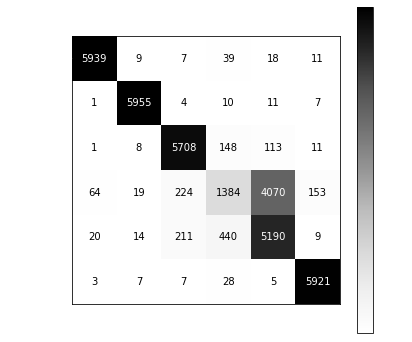

In [124]:
# Plotting a confusion matrix to observe accuracy between cyberbullying types

cm = confusion_matrix(y_labels, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Age','Ethnicity','Gender','None','Other','Religion'])

fig, ax = plt.subplots(figsize=(6,6))
disp.plot(cmap=plt.cm.Greys, ax = ax)

In [128]:
1384/ (64+19+224+4070+153)

0.3055187637969095

## Links

https://medium.com/analytics-vidhya/nlp-tutorial-for-text-classification-in-python-8f19cd17b49e

data - https://www.kaggle.com/datasets/andrewmvd/cyberbullying-classification

https://www.ritchieng.com/machine-learning-multinomial-naive-bayes-vectorization/

https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f

looking at diff models - https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f

